In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../software')
sys.path.insert(0, '../firmware')

In [58]:

import pandas
import seaborn
import numpy
np = numpy
from matplotlib import pyplot as plt

from analysis import load_files
from luxmeter_core import PHOTOPIC_LUMINOUS_EFFICACY
from train import create_pipeline, evaluate_pipeline, IdentityScaler


In [3]:

data = load_files('../data/one', fixup_shape=True)
print(data.shape)
data.head(5)

(1840, 23)


,ch_FZ,ch_FY,ch_FXL,ch_NIR,ch_VIS1_TL,ch_VIS1_BR,ch_F2,ch_F3,ch_F4,ch_F6,...,ch_F7,ch_F8,ch_F5,ch_VIS3_TL,ch_VIS3_BR,datapoint,filename,experiment,lux,colortemp
0,1571,5034,5773,1670,7591,17984,1333,2034,2864,7309,...,5959,1795,1750,7589,17984,0,one_2500k_309lux.npy,one,309,2500
1,1571,5034,5773,1670,7592,17984,1333,2032,2862,7306,...,5961,1794,1750,7592,17980,1,one_2500k_309lux.npy,one,309,2500
2,1571,5037,5775,1670,7593,17984,1334,2032,2863,7307,...,5964,1796,1752,7595,17984,2,one_2500k_309lux.npy,one,309,2500
3,1572,5038,5773,1670,7596,17984,1333,2032,2862,7308,...,5963,1795,1750,7593,17981,3,one_2500k_309lux.npy,one,309,2500
4,1572,5040,5776,1671,7595,17982,1333,2035,2863,7307,...,5960,1795,1751,7592,17979,4,one_2500k_309lux.npy,one,309,2500


In [4]:
from luxmeter_core import AS7343_INFO, photopic_interpolated

channels = pandas.DataFrame(AS7343_INFO).set_index('channel')
channels['sensitivity'] = 155e-3 / channels.counts # radiometric power (W/m²) per "count"
channels['feature'] = [f'ch_{c}' for c in channels.index]
channels['photopic_weight'] = channels.peak_wavelength.apply(photopic_interpolated)
channels['counts_min_rel'] = (100*(channels['counts_min']-channels['counts']) / channels['counts']).round(1)
channels['counts_max_rel'] = (100*(channels['counts_max']-channels['counts']) / channels['counts']).round(1)
channels['counts_range'] = (channels['counts_max']/channels['counts_min']).round(1)
channels

,peak_wavelength_min,peak_wavelength,peak_wavelength_max,FWHM,counts,counts_min,counts_max,sensitivity,feature,photopic_weight,counts_min_rel,counts_max_rel,counts_range
channel,,,,,,,,,,,,,
F1,395,405,415,30,5749,4311,7760,0.000027,ch_F1,0.000640,-25.0,35.0,1.8
F2,415,425,435,22,1756,1317,2371,0.000088,ch_F2,0.007300,-25.0,35.0,1.8
FZ,440,450,460,55,2169,1627,2711,0.000071,ch_FZ,0.038000,-25.0,25.0,1.7
F3,465,475,485,30,770,577,962,0.000201,ch_F3,0.112600,-25.1,24.9,1.7
F4,505,515,525,40,3141,2356,3926,0.000049,ch_F4,0.608200,-25.0,25.0,1.7
FY,545,555,565,100,3747,2810,4684,0.000041,ch_FY,1.000000,-25.0,25.0,1.7
F5,540,550,560,35,1574,1180,1967,0.000098,ch_F5,0.994950,-25.0,25.0,1.7
FXL,590,600,610,80,4776,3582,5970,0.000032,ch_FXL,0.631000,-25.0,25.0,1.7
F6,630,640,650,50,3336,2502,4170,0.000046,ch_F6,0.175000,-25.0,25.0,1.7


In [5]:
sampled = data.groupby('filename', group_keys=False).sample(frac=0.20)

numeric_cols = sampled.select_dtypes(include=['int16', 'float']).columns
sampled[numeric_cols] = sampled[numeric_cols].astype(float)

avg = sampled.groupby('filename').agg('median', numeric_only=True)
#avg = data.groupby('filename').agg('median', numeric_only=True)
avg.head()

,ch_FZ,ch_FY,ch_FXL,ch_NIR,ch_VIS1_TL,ch_VIS1_BR,ch_F2,ch_F3,ch_F4,ch_F6,...,ch_VIS2_BR,ch_F1,ch_F7,ch_F8,ch_F5,ch_VIS3_TL,ch_VIS3_BR,datapoint,lux,colortemp
filename,,,,,,,,,,,,,,,,,,,,,
one_2500k_100lux.npy,274.0,1206.0,1518.0,148.0,2132.0,17981.5,86.0,272.0,560.0,2061.5,...,17974.0,25.0,1537.0,208.0,265.0,2131.5,17978.5,13.5,100.0,2500.0
one_2500k_1lux.npy,5.0,11.0,10.0,16.0,19.0,588.0,2.5,5.0,8.0,13.0,...,588.0,1.0,13.0,9.0,3.0,19.0,588.5,8.0,1.0,2500.0
one_2500k_204lux.npy,737.5,2751.5,3311.5,614.5,4507.0,17983.5,457.5,857.5,1417.0,4351.0,...,17979.0,367.0,3379.5,720.0,777.0,4506.0,17982.5,8.0,204.0,2500.0
one_2500k_309lux.npy,1572.0,5039.0,5776.0,1670.5,7594.5,17981.5,1333.5,2033.5,2863.5,7307.0,...,17984.0,1264.5,5962.0,1796.0,1750.5,7592.0,17984.0,13.0,309.0,2500.0
one_2500k_408lux.npy,2432.0,7321.5,8194.5,2784.5,10596.0,17984.0,2265.5,3259.5,4330.0,10186.0,...,17983.5,2229.0,8516.0,2919.5,2760.0,10596.0,17983.0,11.5,408.0,2500.0


In [59]:


def clean_enrich_data(df):
    
    #sub = avg[avg.colortemp == 2500]
    sub = df.copy()

    # remove problematic outliers
    sub = sub[sub.index != 'rgb1_280h_445lux.npy']
    sub = sub[sub.index != 'rgb33_0h_55lux.npy']
    #sub = sub[sub.index != 'one_2500k_589lux.npy']
    sub = sub[sub.index != 'one_2500k_592lux.npy']

    # avoid including both FY and F5, because overlapping
    narrowband = list(set([c for c in sub.columns if c.startswith('ch_F')]) - set(['ch_FY']))

    # Baseline computation of lux, using the photopic function directly
    # assumes that our channels measures perfectly
    chan = channels.reset_index().set_index('feature')
    sub['energy_photopic'] = (sub[narrowband] * chan.photopic_weight).sum(axis=1)

    # Scale down energy, to make feature/channel coefficients close to 1.0
    sub['energy_labeled'] = sub['lux'] / PHOTOPIC_LUMINOUS_EFFICACY
    
    return sub

sub = clean_enrich_data(avg)
sub.head()

,ch_FZ,ch_FY,ch_FXL,ch_NIR,ch_VIS1_TL,ch_VIS1_BR,ch_F2,ch_F3,ch_F4,ch_F6,...,ch_F7,ch_F8,ch_F5,ch_VIS3_TL,ch_VIS3_BR,datapoint,lux,colortemp,energy_photopic,energy_labeled
filename,,,,,,,,,,,,,,,,,,,,,
one_2500k_100lux.npy,274.0,1206.0,1518.0,148.0,2132.0,17981.5,86.0,272.0,560.0,2061.5,...,1537.0,208.0,265.0,2131.5,17978.5,13.5,100.0,2500.0,1977.211769,0.146413
one_2500k_1lux.npy,5.0,11.0,10.0,16.0,19.0,588.0,2.5,5.0,8.0,13.0,...,13.0,9.0,3.0,19.0,588.5,8.0,1.0,2500.0,17.315618,0.001464
one_2500k_204lux.npy,737.5,2751.5,3311.5,614.5,4507.0,17983.5,457.5,857.5,1417.0,4351.0,...,3379.5,720.0,777.0,4506.0,17982.5,8.0,204.0,2500.0,4641.900657,0.298682
one_2500k_309lux.npy,1572.0,5039.0,5776.0,1670.5,7594.5,17981.5,1333.5,2033.5,2863.5,7307.0,...,5962.0,1796.0,1750.5,7592.0,17984.0,13.0,309.0,2500.0,8755.130440,0.452416
one_2500k_408lux.npy,2432.0,7321.5,8194.5,2784.5,10596.0,17984.0,2265.5,3259.5,4330.0,10186.0,...,8516.0,2919.5,2760.0,10596.0,17983.0,11.5,408.0,2500.0,12880.666289,0.597365


Fitting 5 folds for each of 25 candidates, totalling 125 fits

Metrics Comparison:
Metric                    Train        Test         Difference  
-----------------------------------------------------------------
R² Score                  0.8084       0.7693       0.0391      
RMSE                      97.2499      104.0524     6.8025      
Mean Absolute Error       72.4427      91.5200      19.0773     
Sample Size               57           32          
Unknown feature energy_photopic
Saved luxmeter_photopic_function__gridsearch.png


/tmp/ipykernel_1087198/321133158.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Saved luxmeter_photopic_function__sparsity.png
Saved luxmeter_photopic_function__features.png
Saved luxmeter_photopic_function__predictions.png
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Metrics Comparison:
Metric                    Train        Test         Difference  
-----------------------------------------------------------------
R² Score                  0.5813       0.6479       0.0666      
RMSE                      135.1534     142.9079     7.7545      
Mean Absolute Error       110.2226     115.4005     5.1778      
Sample Size               57           32          
Saved luxmeter_fy_channel_only__gridsearch.png


/tmp/ipykernel_1087198/321133158.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Saved luxmeter_fy_channel_only__sparsity.png
Saved luxmeter_fy_channel_only__features.png
Saved luxmeter_fy_channel_only__predictions.png
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Metrics Comparison:
Metric                    Train        Test         Difference  
-----------------------------------------------------------------
R² Score                  0.9998       0.9988       0.0010      
RMSE                      3.2488       6.7133       3.4645      
Mean Absolute Error       2.0216       4.8570       2.8354      
Sample Size               59           30          
Saved luxmeter_all_channels__gridsearch.png


/tmp/ipykernel_1087198/321133158.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Saved luxmeter_all_channels__sparsity.png
Saved luxmeter_all_channels__features.png
Saved luxmeter_all_channels__predictions.png


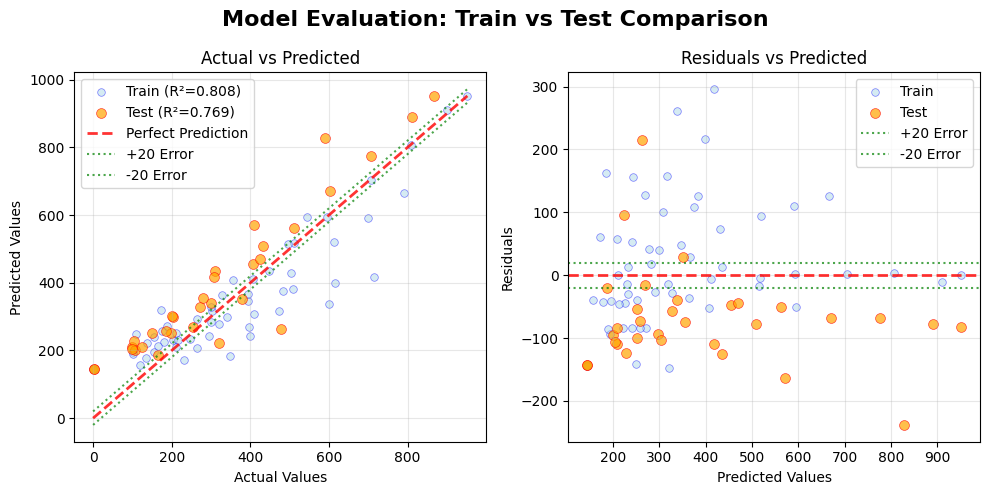

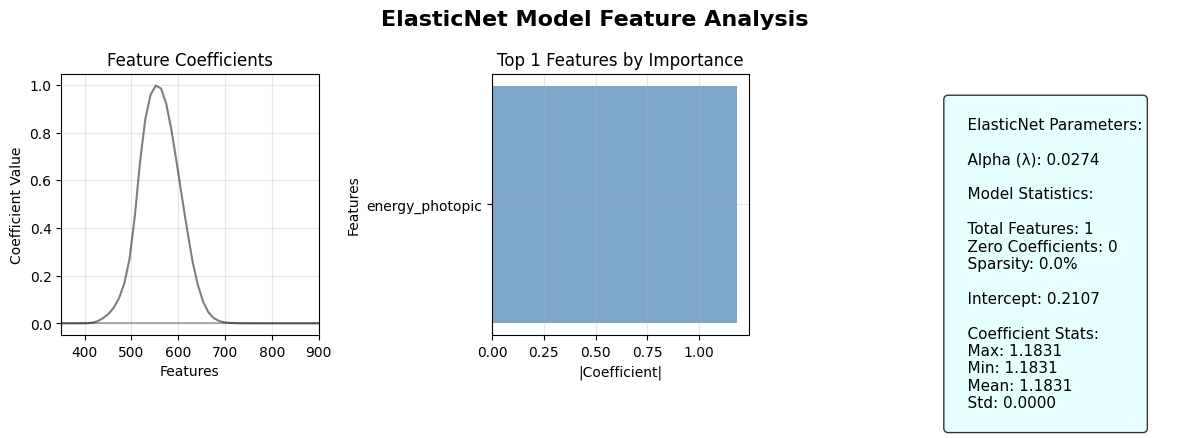

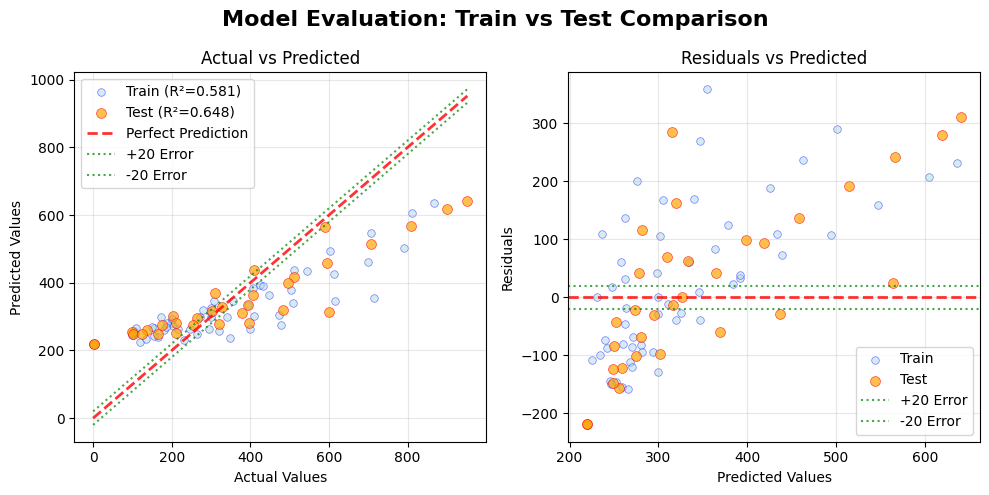

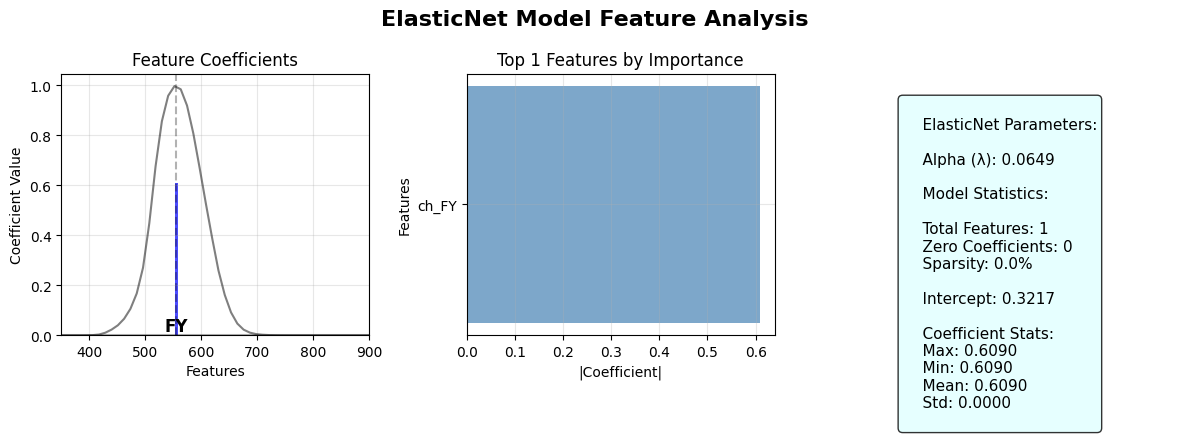

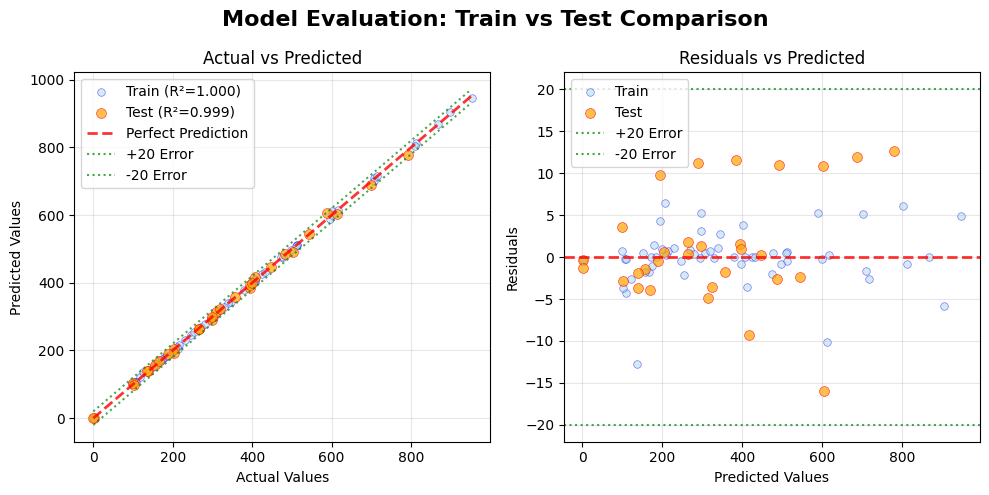

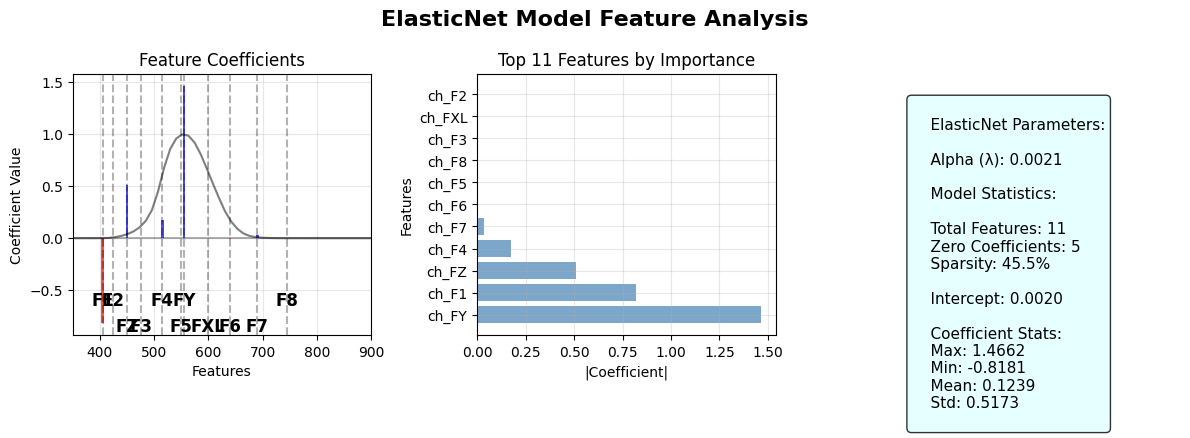

In [62]:


EXPERIMENTS=[
    dict(name='Photopic function', features=['energy_photopic']),
    dict(name='FY channel only', features=['ch_FY']),
    dict(name='All channels', features=None),
]

from preprocessing import FixedScaler

def run_experiment(experiment):

    # Setup scaling of the input data based on the specified sensitivity of the AS7343
    scale = channels.copy().set_index('feature').rename(columns={'sensitivity': 'scale'})
    scale['shift'] = 0.0
    scaler = FixedScaler(scale)

    # TODO: export PNG files
    est = create_pipeline(positive=False, scaler=scaler, fit_intercept=True)
    enabled_features = experiment['features']
    pipeline, features, predictions, figures = evaluate_pipeline(est, sub, features=enabled_features, scale_predict=PHOTOPIC_LUMINOUS_EFFICACY, target='energy_labeled')
    for name, fig in figures.items():
        if name not in ['features', 'predictions']:
            plt.close(fig) # do not show

        plot_path = f'luxmeter_{experiment["name"]}__{name}.png'.replace(' ', '_').lower()
        fig.savefig(plot_path)
        print('Saved', plot_path)
        fig.show()

    return pipeline, features

for ex in EXPERIMENTS:
    pipeline, features = run_experiment(ex)


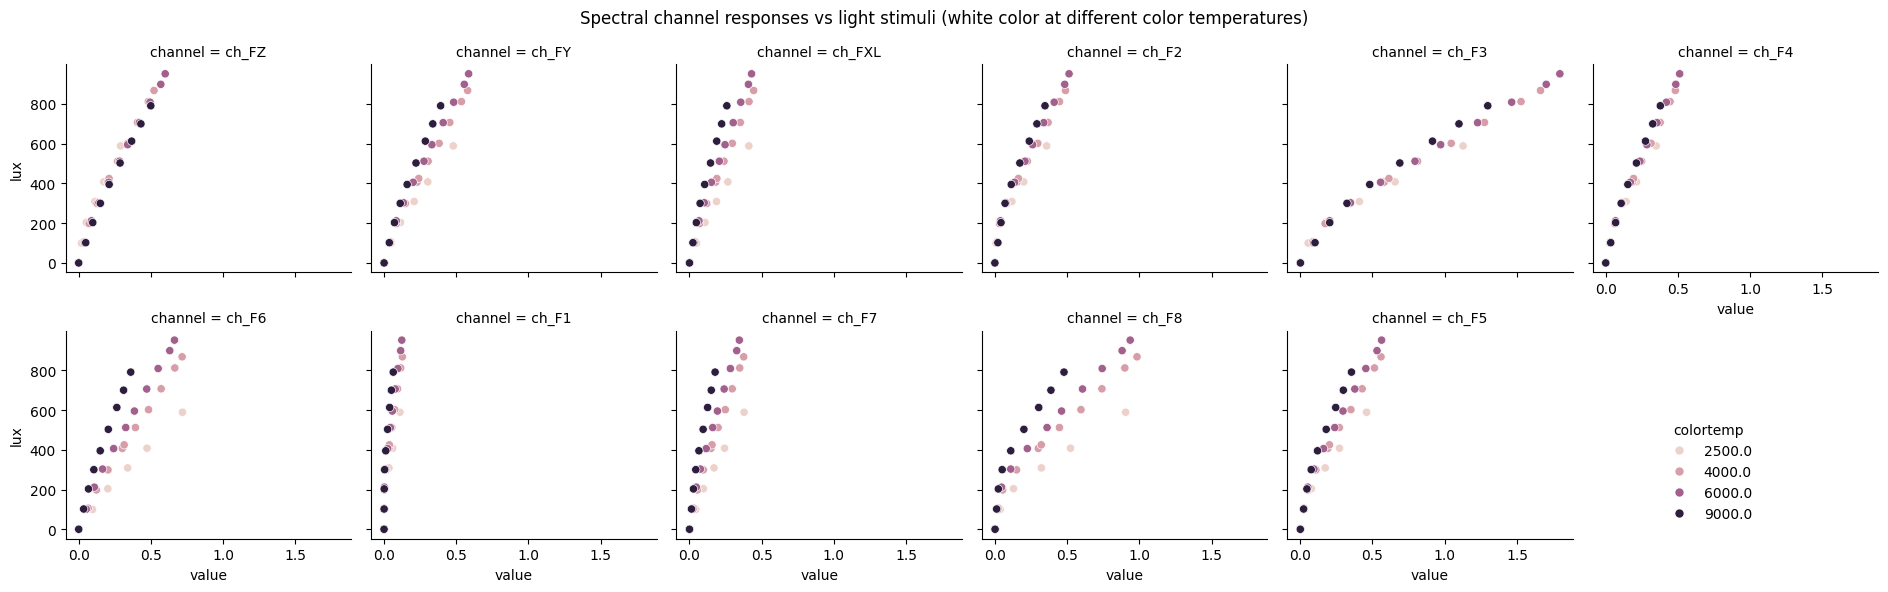

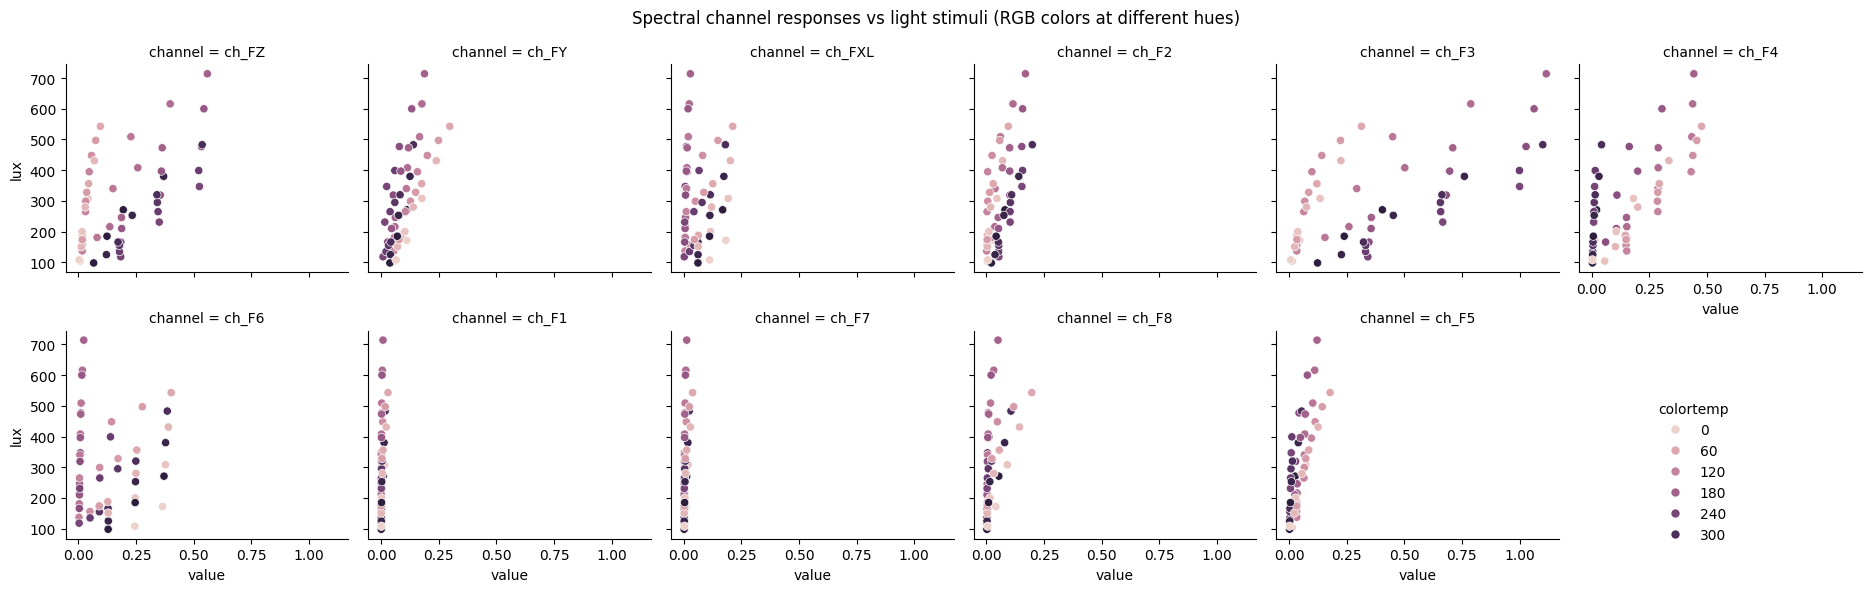

In [54]:

def plot_channels(df, hue='colortemp', target='lux', col_wrap=6, title=''):
    channels = [c for c in sub.columns if 'ch_F' in c ]
    #seaborn.pairplot(d, y_vars=conditions, x_vars=channels, col_wrap=col_wrap, hue=hue)
    # TODO: put channel order
    # TODO: put wavelength in plot names
    # TODO: colorize by rgb ?
    melted = pandas.melt(df.reset_index(), id_vars=['filename', 'colortemp', 'lux'], var_name='channel', value_vars=channels)
    g = seaborn.relplot(data=melted, hue=hue, y=target, x='value', col='channel', col_wrap=col_wrap, height=3.0, legend=True)

    fig = g.figure
    
    legend = g._legend
    legend.set_bbox_to_anchor((0.9, 0.2))
    legend.set_loc('center')
    
    g.figure.suptitle(title)
    #eaborn.pairplot(d, y='lux', x_vars=channels, col_wrap=col_wrap, hue=hue)

    #ax = g.axes[-2, -1]  # Second-to-last row, last column
    #ax.legend()
    
    g.figure.tight_layout()

    return g.figure

whites = sub[sub.colortemp > 1000]
fig = plot_channels(whites, title='Spectral channel responses vs light stimuli (white color at different color temperatures)');
fig.savefig('luxmeter_channel_response_white.png')

colors = sub[sub.colortemp < 1000]
fig = plot_channels(colors, title='Spectral channel responses vs light stimuli (RGB colors at different hues)');
fig.savefig('luxmeter_channel_response_rgb.png')

In [63]:
from luxmeter_core import AS7343_CHANNEL_MAP


def export_model(out, pipeline, features):

    scaler = pipeline.named_steps['scaler']
    regressor = pipeline.named_steps['regressor']
    assert len(pipeline.named_steps) == 2, pipeline.named_steps
    
    # We adapt the model to respect the original ordering/number of channels
    # Unused features will just be zeroed
    all_channels = AS7343_CHANNEL_MAP
    n_channels = len(all_channels)
    scale_min = numpy.zeros(n_channels)
    scale_mul = numpy.zeros(n_channels)
    regressor_weights = numpy.zeros(n_channels)
    
    for channel_idx, channel in enumerate(all_channels):
        feature = 'ch_'+channel
        if feature not in features:
            #print('Unused', channel, feature)
            continue
        feature_idx = features.index(feature)
        scale_min[channel_idx] = scaler.min_[feature_idx]
        scale_mul[channel_idx] = scaler.scale_[feature_idx]
        regressor_weights[channel_idx] = regressor.coef_[feature_idx]

    # Duplicate bias just to make it compatible in shape with the rest
    regressor_bias = numpy.array([regressor.intercept_] * n_channels)
    
    combined = numpy.stack([ scale_min, scale_mul, regressor_bias, regressor_weights ]).astype(float)
    print(combined)
    
    numpy.save(out, combined)

out_path = 'pipeline.npy'
export_model(out_path, pipeline, features)

[[-5.96658711e-04 -7.77440102e-04 -7.30486869e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -5.15774091e-04 -5.60381059e-04
  -7.23100656e-04 -8.43799695e-04  0.00000000e+00  0.00000000e+00
  -2.12743325e-04 -9.49884114e-04 -1.64338537e-03 -5.25118152e-04
   0.00000000e+00  0.00000000e+00]
 [ 1.19331742e-04  7.06763729e-05  7.30486869e-05  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.71924697e-04  1.12076212e-04
   9.64134207e-05  6.49076688e-05  0.00000000e+00  0.00000000e+00
   2.12743325e-04  7.59907291e-05  1.82598375e-04  1.75039384e-04
   0.00000000e+00  0.00000000e+00]
 [ 2.01522281e-03  2.01522281e-03  2.01522281e-03  2.01522281e-03
   2.01522281e-03  2.01522281e-03  2.01522281e-03  2.01522281e-03
   2.01522281e-03  2.01522281e-03  2.01522281e-03  2.01522281e-03
   2.01522281e-03  2.01522281e-03  2.01522281e-03  2.01522281e-03
   2.01522281e-03  2.01522281e-03]
 [ 5.11272104e-01  1.46621754e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import colour

def hue_to_spectrum_colour(hue, saturation=1.0):
    """Convert HSL hue to LED spectrum using manual HSL conversion"""
    # LED specifications
    leds = {
        'red': {'peak': 625, 'fwhm': 20},
        'green': {'peak': 525, 'fwhm': 35}, 
        'blue': {'peak': 465, 'fwhm': 25}
    }
    
    # Manual HSL to RGB conversion (the one that was working)
    h = (hue % 360) / 360
    def hue_to_rgb_component(p, q, t):
        if t < 0: t += 1
        if t > 1: t -= 1
        if t < 1/6: return p + (q - p) * 6 * t
        if t < 1/2: return q
        if t < 2/3: return p + (q - p) * (2/3 - t) * 6
        return p
    
    q = 0.5 + 0.5 * saturation
    p = 1 - saturation
    
    rgb = np.array([
        hue_to_rgb_component(p, q, h + 1/3),  # Red
        hue_to_rgb_component(p, q, h),        # Green  
        hue_to_rgb_component(p, q, h - 1/3)   # Blue
    ])
    
    print(f"Hue {hue}°: RGB={rgb}")  # Debug print
    
    # Create Gaussian LED spectra
    wavelengths = np.arange(400, 700, 1)
    spectrum_dict = {}
    
    led_colors = ['red', 'green', 'blue']
    for i, color in enumerate(led_colors):
        if rgb[i] > 0:
            # Gaussian spectrum for this LED
            peak = leds[color]['peak']
            fwhm = leds[color]['fwhm']
            sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
            
            led_spectrum = rgb[i] * np.exp(-0.5 * ((wavelengths - peak) / sigma) ** 2)
            
            # Add to spectrum dictionary
            for j, wl in enumerate(wavelengths):
                if led_spectrum[j] > 0:
                    spectrum_dict[wl] = spectrum_dict.get(wl, 0) + led_spectrum[j]
    
    # Create SpectralDistribution object
    sd = colour.SpectralDistribution(spectrum_dict, name=f'Hue {hue}°')
    
    return sd, rgb

def wavelength_to_rgb_colour(wavelength):
   """Simple wavelength to RGB conversion"""
   if 380 <= wavelength < 440:
       R = -(wavelength - 440) / (440 - 380)
       G = 0.0
       B = 1.0
   elif 440 <= wavelength < 490:
       R = 0.0
       G = (wavelength - 440) / (490 - 440)
       B = 1.0
   elif 490 <= wavelength < 510:
       R = 0.0
       G = 1.0
       B = -(wavelength - 510) / (510 - 490)
   elif 510 <= wavelength < 580:
       R = (wavelength - 510) / (580 - 510)
       G = 1.0
       B = 0.0
   elif 580 <= wavelength < 645:
       R = 1.0
       G = -(wavelength - 645) / (645 - 580)
       B = 0.0
   elif 645 <= wavelength <= 780:
       R = 1.0
       G = 0.0
       B = 0.0
   else:
       R = G = B = 0.0
   
   return (R, G, B)


def plot_hue_spectrum(ax, hue, saturation=1.0):
    """Plot spectrum for a given hue using colour-science objects"""
    sd, rgb_weights = hue_to_spectrum_colour(hue, saturation)
    
    # Get wavelengths and values from SpectralDistribution
    wavelengths = sd.wavelengths
    values = sd.values
    
    # Create wavelength color background
    wl_range = np.arange(400, 700, 5)
    for wl in wl_range:
        rgb = wavelength_to_rgb_colour(wl)
        ax.axvspan(wl-2.5, wl+2.5, color=rgb, alpha=0.3, zorder=0)
    
    # Plot spectrum
    ax.plot(wavelengths, values, 'k-', linewidth=2, zorder=2)
    ax.set_ylabel('Intensity')
    ax.set_title(f'Hue {hue}° | RGB: ({rgb_weights[0]:.2f}, {rgb_weights[1]:.2f}, {rgb_weights[2]:.2f})')
    ax.grid(True, alpha=0.5, zorder=1)
    ax.set_xlim(400, 700)
    ax.set_ylim(0, None)

# Plot multiple hues in single column
N = 8
hues = np.linspace(0, 360, N, endpoint=False)

fig, axes = plt.subplots(N, 1, figsize=(12, 2.0*N), sharex=True)

for i, hue in enumerate(hues):
    plot_hue_spectrum(axes[i], hue, saturation=0.8)

for ax in axes[:-1]:
    ax.set_xlabel('')
    
axes[-1].set_xlabel('Wavelength (nm)')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import colour

def temp_to_rgb_colour(temp_k):
    """Convert color temperature to tinted white"""
    # Get the color temperature tint
    xy = colour.CCT_to_xy(temp_k)
    XYZ = colour.xy_to_XYZ(xy) * 95
    RGB = colour.XYZ_to_sRGB(XYZ / 100)
    RGB = np.clip(RGB, 0, 1)
    
    # Mix with white to create tinted white
    white = np.array([1.0, 1.0, 1.0])
    tint_strength = 0.2  # How much tint vs pure white
    
    tinted_white = (1 - tint_strength) * white + tint_strength * RGB
    
    return tinted_white

def plot_temp_spectrum(ax, temp_k):
   """Plot blackbody spectrum for given temperature with RGB color patch"""
   # Get blackbody spectral distribution
   sd = colour.sd_blackbody(temp_k, colour.SpectralShape(360, 780, 1))
   wavelengths = sd.wavelengths
   values = sd.values
   
   # Get RGB color for this temperature
   rgb = temp_to_rgb_colour(temp_k)
   
   # Create wavelength color background
   wl_range = np.arange(400, 700, 5)
   for wl in wl_range:
       wl_rgb = wavelength_to_rgb_colour(wl)
       ax.axvspan(wl-2.5, wl+2.5, color=wl_rgb, alpha=0.3, zorder=0)
   
   # Plot spectrum
   ax.plot(wavelengths, values, 'k-', linewidth=2, zorder=2)
   
   # Add RGB color rectangle in top-right corner
   from matplotlib.patches import Rectangle
   rect = Rectangle((650, 0.8 * np.max(values)), 40, 0.15 * np.max(values), 
                    facecolor=rgb, edgecolor='black', linewidth=1, zorder=3)
   ax.add_patch(rect)
   
   ax.set_ylabel('Intensity')
   ax.set_title(f'{temp_k}K | RGB: ({rgb[0]:.2f}, {rgb[1]:.2f}, {rgb[2]:.2f})', loc='left')
   ax.grid(True, alpha=0.5, zorder=1)
   ax.set_xlim(400, 700)
   ax.set_ylim(0, None)

# Plot different color temperatures
temps = [2500, 3200, 4000, 5600, 6500, 9000]  # Kelvin

fig, axes = plt.subplots(len(temps), 1, figsize=(10, 2.0*len(temps)))

for i, temp in enumerate(temps):
   plot_temp_spectrum(axes[i], temp)

# Only show x-axis label on bottom plot
for ax in axes[:-1]:
   ax.set_xlabel('')
   
axes[-1].set_xlabel('Wavelength (nm)')

plt.tight_layout()
plt.show()